- pip install langgraph
- pip install langchain       
- pip install langchain-openai   
- pip install langchain-community

In [11]:
from dotenv import load_dotenv
import os
# 从 .env 文件加载环境变量
load_dotenv()

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

token = os.environ["GITHUB_TOKEN"]
endpoint = "https://models.github.ai/inference"
model = "openai/gpt-4.1"

tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json



 `AgentState` 类定义了整个Agent系统的**状态结构**，它是所有节点之间共享数据的核心容器。可以把它想象成Agent的"记忆系统"或"信息载体"，在整个工作流程中传递和更新数据。

`AgentState` 继承自 `TypedDict`，这是Python中一种特殊的字典类型，它为字典的键值对提供了类型注解。这样做的好处是既保持了字典的灵活性，又增加了类型安全性，让IDE和类型检查工具能够帮助我们发现潜在的错误。

类中只定义了一个字段 `messages`，它的类型是 `Annotated[list[AnyMessage], operator.add]`。这个复杂的类型注解包含了三个重要信息：首先，`list[AnyMessage]` 表示这是一个消息列表，其中每个元素都是 `AnyMessage` 类型（可以是用户消息、AI回复、系统消息或工具消息等）；其次，`Annotated` 是Python的类型注解工具，允许我们为类型添加额外的元数据；最后，`operator.add` 是关键的元数据，它告诉LangGraph当多个节点返回消息时应该如何合并它们。

`operator.add` 的作用非常重要。当不同的节点（比如AI思考节点或工具执行节点）都返回新的消息时，LangGraph会自动使用加法运算符（`+`）来合并这些消息列表。例如，如果当前状态有 `[消息1, 消息2]`，而某个节点返回 `[消息3]`，那么最终状态会变成 `[消息1, 消息2, 消息3]`。这种自动合并机制确保了对话历史的连续性和完整性。

这种设计使得Agent能够在每个处理步骤中都保持完整的上下文信息。无论是AI模型需要回顾之前的对话来做出决策，还是工具执行完毕后需要将结果添加到对话历史中，这个状态结构都能够无缝地支持这些操作，为整个Agent系统提供了可靠的数据流转基础。

In [12]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.


## LangGraph Agent整体概述

这个 `Agent` 类创建了一个**工作流图**，让AI模型能够：
1. 思考问题
2. 决定是否需要使用工具
3. 执行工具
4. 根据结果继续思考

就像人类解决问题的过程一样！

## 详细分析

### 1. 初始化方法 (`__init__`)

```python
def __init__(self, model, tools, system=""):
    self.system = system  # 系统提示词，告诉AI它的角色
    
    # 创建状态图 - 这是整个工作流的基础
    graph = StateGraph(AgentState)
    
    # 添加两个核心节点
    graph.add_node("llm", self.call_openai)      # AI思考节点
    graph.add_node("action", self.take_action)   # 工具执行节点
    
    # 添加条件分支 - AI决定下一步做什么
    graph.add_conditional_edges(
        "llm",                    # 从AI节点出发
        self.exists_action,       # 判断函数：是否需要使用工具？
        {True: "action", False: END}  # True=去执行工具，False=结束
    )
    
    # 工具执行完后，回到AI继续思考
    graph.add_edge("action", "llm")
    
    # 设置入口点 - 从AI开始
    graph.set_entry_point("llm")
    
    # 编译图并准备工具
    self.graph = graph.compile()
    self.tools = {t.name: t for t in tools}  # 工具字典，方便查找
    self.model = model.bind_tools(tools)     # 让模型知道可用工具

```



**关键概念解释：**
- **StateGraph**: 想象成一个流程图，定义了AI的工作步骤
- **节点 (node)**: 流程图中的每个步骤/功能
- **边 (edge)**: 连接节点的箭头，决定执行顺序
- **条件边**: 根据条件选择不同的下一步

### 2. 判断是否需要工具 (`exists_action`)

```python
def exists_action(self, state: AgentState):
    result = state['messages'][-1]  # 获取最新消息
    return len(result.tool_calls) > 0  # 检查是否有工具调用请求

```


这个函数像一个**决策器**：
- 查看AI的最新回复
- 如果AI想使用工具 → 返回 `True`
- 如果AI只是普通回复 → 返回 `False`

### 3. AI思考节点 (`call_openai`)

```python
def call_openai(self, state: AgentState):
    messages = state['messages']  # 获取对话历史
    
    # 如果有系统提示词，添加到消息开头
    if self.system:
        messages = [SystemMessage(content=self.system)] + messages
    
    # 调用AI模型获取回复
    message = self.model.invoke(messages)
    return {'messages': [message]}  # 返回新消息

```


**工作流程：**
1. 收集到目前为止的所有对话
2. 添加系统角色设定（如果有）
3. 让AI模型思考并生成回复
4. 回复可能包含文字答案或工具使用请求

### 4. 工具执行节点 (`take_action`)

```python
def take_action(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls  # 获取工具调用请求
    results = []
    
    for t in tool_calls:  # 遍历每个工具调用
        print(f"Calling: {t}")
        
        # 安全检查：工具名称是否存在
        if not t['name'] in self.tools:
            print("\n ....bad tool name....")
            result = "bad tool name, retry"  # 告诉AI重试
        else:
            # 执行工具并获取结果
            result = self.tools[t['name']].invoke(t['args'])
        
        # 创建工具结果消息
        results.append(ToolMessage(
            tool_call_id=t['id'], 
            name=t['name'], 
            content=str(result)
        ))
    
    print("Back to the model!")
    return {'messages': results}  # 返回所有工具执行结果
```


**关键安全特性：**
- **错误处理**: 如果AI请求不存在的工具，会友好地告诉它重试
- **多工具支持**: 可以同时执行多个工具
- **结果追踪**: 每个工具结果都有唯一ID，确保AI知道哪个结果对应哪个请求

## 执行流程示例

假设用户问："今天天气如何？"

1. 用户输入 → Agent
2. "llm"节点: AI思考 → "我需要查询天气工具"
3. exists_action: 发现有工具调用 → 路由到"action"
4. "action"节点: 执行天气查询工具 → 获取天气数据
5. 自动回到"llm"节点: AI整理结果 → "今天晴天，温度25°C"
6. exists_action: 无更多工具调用 → 结束(END)


## 设计优势

1. **模块化**: 思考和行动分离，便于维护
2. **可扩展**: 可以轻松添加新工具
3. **鲁棒性**: 有错误处理机制
4. **循环能力**: AI可以多次使用工具直到解决问题
5. **状态管理**: 保持完整的对话历史



In [13]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [20]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(
    base_url=endpoint,
    api_key=token,
    model="openai/gpt-4.1",
)  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

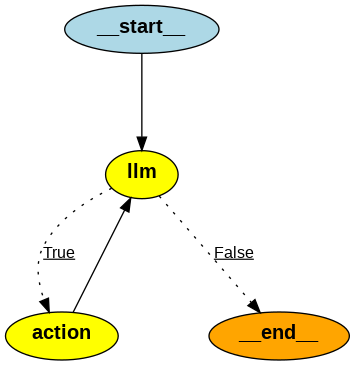

In [15]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [21]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_bDJsEiNs2eq092XvXatrT9Gk', 'type': 'tool_call'}
Back to the model!


In [24]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FHWIrtJevt8oZCf4wtuJTAXK', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 151, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_b663f05c2c', 'id': 'chatcmpl-ByqEznVSjGgEK7jp6GSDKAd4Sj6e1', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--67d3a4a3-74cd-4f80-96c6-5c7e46126be8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather

In [25]:
result['messages'][-1].content

'The current weather in San Francisco is about 63°F and partly sunny. The weekend is expected to have a mix of clouds and sun. If you need more detailed or current information, let me know!'

In [26]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_pfxsoLdB9nL1CJXrz562lFuM', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_XHHZeNerEeq2z1WWRZhr3hAG', 'type': 'tool_call'}
Back to the model!


In [27]:
result['messages'][-1].content

'Here is the current weather for both cities:\n\nSan Francisco (SF):\n- Tonight: Partly cloudy with fog developing late, low around 56°F (13°C). Winds west at 15 to 25 mph.\n- Tomorrow: Considerable cloudiness, mist possible, high around 65°F (18°C). Winds WSW at 15 to 25 mph.\n\nLos Angeles (LA):\n- Tonight: Partly to mostly cloudy, low around 62°F (17°C). Winds light and variable.\n- Tomorrow: Typically sunny and warm for July, highs around 82°F (28°C) and lows near 64°F (18°C).\n\nLet me know if you need more details or a longer forecast!'

In [29]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Super Bowl in 2024?'}, 'id': 'call_mAhY0ZHa0ty9APWmHSbH0yrW', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'List of US states by GDP 2024'}, 'id': 'call_V8yamfbm5zpLHMJHMJ3FvuCr', 'type': 'tool_call'}
Back to the model!


In [30]:
print(result['messages'][-1].content)

Here are answers to your three questions:

1. Who won the Super Bowl in 2024?
   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in overtime by a score of 25-22.

2. In what state is the winning team headquarters located?
   - The Kansas City Chiefs are headquartered in the state of Missouri.

3. What is the GDP of that state?
   - Missouri's GDP in 2024 is not among the top-ranked states and specific figures don't appear in the highest lists above. However, Missouri's GDP in recent years has been approximately $370–$380 billion. (For comparison: California, Texas, and New York, the largest state economies, have GDPs of over $2 trillion.)

If you want the most precise and current Missouri GDP figure for 2024, let me know and I can retrieve it!
